In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from cv2 import *

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import pathlib
train_dir=pathlib.Path('/content/drive/MyDrive/FinalProject/train')
test_dir=pathlib.Path('/content/drive/MyDrive/FinalProject/test')

In [ ]:
batch_size = 10
img_height = 224
img_width = 224

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='categorical')

Found 6812 images belonging to 4 classes.


In [ ]:
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator .flow_from_directory(batch_size=batch_size,
                                                        directory=test_dir,
                                                        shuffle=True,
                                                        target_size=(img_height, img_width),
                                                        class_mode='categorical')

Found 49 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
IMAGE_SIZE = [224, 224]
base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
base_model.trainable = False

In [ ]:


cnn_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])

In [ ]:
cnn_model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
#history = cnn_model.fit(train_data_gen, epochs=1,
#validation_data= val_data_gen,)

save_path = './keras-saves/_latest.ckpt'
try:
    history = cnn_model.fit(train_data_gen,validation_data= val_data_gen,
              epochs=4)
    cnn_model.save('/content/drive/MyDrive/FinalProject/Model/model.tflite')
except KeyboardInterrupt:
    cnn_model.save(save_path)
    print('Output saved to: "{}./*"'.format(save_path))

Epoch 1/4
682/682 [==============================] - 1174s 2s/step - loss: 0.3036 - accuracy: 0.8943 - val_loss: 0.7381 - val_accuracy: 0.7959
Epoch 2/4
682/682 [==============================] - 1167s 2s/step - loss: 0.1783 - accuracy: 0.9347 - val_loss: 0.4098 - val_accuracy: 0.8163
Epoch 3/4
682/682 [==============================] - 1112s 2s/step - loss: 0.1411 - accuracy: 0.9498 - val_loss: 0.0798 - val_accuracy: 1.0000
Epoch 4/4
682/682 [==============================] - 1116s 2s/step - loss: 0.1102 - accuracy: 0.9593 - val_loss: 0.1367 - val_accuracy: 0.9592


In [ ]:
test_img,labels=val_data_gen.next()
class_names=['cocci','healthy','ncd','salmo']
test_img.dtype
cl=cnn_model.predict(test_img)
labels

1/1 [==============================] - 2s 2s/step


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

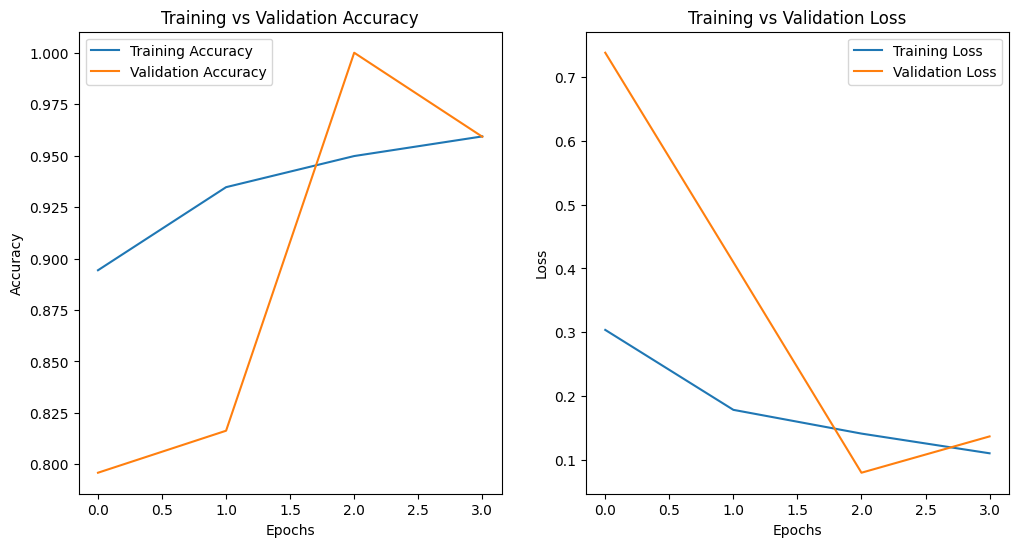

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training vs Validation accuracy
# Plot Training vs Validation accuracy and Training vs Validation loss in a single row
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training vs Validation accuracy
axs[0].plot(train_acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Training vs Validation loss
axs[1].plot(train_loss, label='Training Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()



In [ ]:
def plotImages(img_arr,label):
  classification=cnn_model.predict(img_arr)
  print(classification)
  for idx, img in enumerate(img_arr):

      plt.figure(figsize=(5,5))
      plt.imshow(img)
      index=np.argmax(classification[idx])
      i=np.argmax(label[idx])

      plt.title("Pred: "+class_names[index]+" | Real: "+class_names[i])
      plt.axis=False
      plt.show()

plotImages(test_img,labels.astype("uint8"))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model=converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)